In [1]:
import sys
import json

torch.manual_seed(0)
sys.path.append('../../')

In [2]:
from utils import *  # ../../utils.py

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

<h1>2-3. FastText<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#LR-range-test" data-toc-modified-id="LR-range-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LR range test</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Embedding-plot" data-toc-modified-id="Embedding-plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Embedding plot</a></span></li><li><span><a href="#$n$-most-similar" data-toc-modified-id="$n$-most-similar-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>$n$-most similar</a></span></li></ul></li></ul></div>

## Prepare data

Use subsampling + negative sampling data created in `2-2_skip-gram.ipynb`.

In [4]:
words, vocab, freq, word_to_ix = get_gutenberg_tokens()

In [5]:
with open("./negative_sampling.json") as r:
    data = json.load(r)

In [6]:
x = data["data"]
y = data["label"]

In [7]:
trainset = torch.utils.data.TensorDataset(torch.LongTensor(x),
                                          torch.Tensor(y))
trainset = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

* build subword data

`≤`, `≥` are SOF, EOF character, respectively

In [8]:
vocab_ = ["≤"+v+"≥" for v in vocab]
words_ = ["≤"+w+"≥" for w in words]

In [9]:
def ngramify(w, n=3):
    len_w = len(w)
    if len_w <= n:
        return [w]
    else:
        return [w[i:i+n] for i in range(len(w)-n+1)]

def split_to_subword(words_, subword_len=3):
    subwords = []
    for w in words_:
        subwords += ngramify(w, subword_len)
    return subwords

In [10]:
subvocab = list(set(split_to_subword(vocab_)))
sv_to_ix = {k: v for v, k in enumerate(subvocab)}
subvocab[:10]

['gun', 'job', 'oxu', 'pii', 'ivl', 'ves', '≤sq', '≤20', 'een', 'nme']

In [11]:
# convert word idx to subword idxs
subword_ixs = [list(map(lambda x: sv_to_ix[x], ngramify(v))) for v in vocab_]
wordix_to_subwordix = {wordix: subwordix for wordix, subwordix in enumerate(subword_ixs)}

In [12]:
list(wordix_to_subwordix.items())[:5]

[(0, [7431]),
 (1, [4429, 846, 6320, 5894]),
 (2, [4754, 6717]),
 (3, [2450, 734, 1167, 5972]),
 (4, [6083, 2406, 720, 4094, 2371, 1385])]

## Build the model

Similar to skip gram, but with subword information.

$$ y = \sigma\left(\sum_{g\in\mathcal{G}_w} z_g'v_c\right) $$

where $\mathcal{G}_w$ is the subword set of the word $w$. Note that for contexts we use only word-level information.

In [13]:
SUBVOCAB_SIZE = len(subvocab)
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100

In [14]:
def get_subword(sample):
    return list(map(
        lambda w: wordix_to_subwordix[w.item()], 
        sample
    ))

In [15]:
class FastText(nn.Module):
    def __init__(self, subvocab_size, vocab_size, embedding_dim):
        super(FastText, self).__init__()
        
        # embeddings
        self.embedding_z = nn.Embedding(subvocab_size, embedding_dim)
        self.embedding_v = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        # input should be of shape [batch_size, 1+k, 2]
        # split positive and negative sample
        x_pos_1, x_pos_2 = x[:, 0, :].T
        x_neg_1, x_neg_2 = x[:, 1:, :].T
        
        # get subwords
        ## positive
        x_pos_1_sub = get_subword(x_pos_1)
        ## negative
        k = x_neg_1.shape[0]
        x_neg_1_sub = [get_subword(x_neg_1[i]) for i in range(k)]
        
        # log-likelihood w.r.t. positive sample
        ## sum up subword vectors to get word vector
        u = [self.embedding_z(torch.cuda.LongTensor(subwords)).sum(dim=0)\
             for subwords in x_pos_1_sub]
        u = torch.stack(u)
        v = self.embedding_v(x_pos_2)
        x_pos = (u * v).sum(dim=1).view(1, -1)
        
        # log-likelihood w.r.t. negative sample
        ## sum up subword vectors to get word vector
        u = [torch.stack([self.embedding_z(torch.cuda.LongTensor(subwords)).sum(dim=0)\
                        for subwords in x_neg_1_sub[i]]) for i in range(k)]
        u = torch.stack(u)
        v = self.embedding_v(x_neg_2)
        x_neg = (u * v).sum(dim=2)
        
        x = torch.cat((x_pos, x_neg)).T
        
        return x

## Train the model

### LR range test

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.84E+01


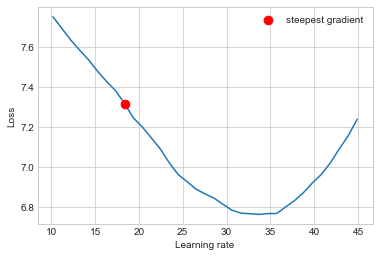

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 18.36735326530612)

In [21]:
from torch_lr_finder import LRFinder

model = FastText(SUBVOCAB_SIZE, VOCAB_SIZE, EMBEDDING_DIM)
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainset, end_lr=50, num_iter=50, step_mode="linear")
lr_finder.plot(log_lr=False)

In [21]:
model = FastText(SUBVOCAB_SIZE, VOCAB_SIZE, EMBEDDING_DIM)
model.to(device)

FastText(
  (embedding_z): Embedding(7486, 100)
  (embedding_v): Embedding(42339, 100)
)

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [23]:
def accuracy(pred):
    pred = (torch.sigmoid(pred) > 0.5).int()
    target = torch.cuda.LongTensor([1, 0, 0])
    correct = ((pred == target).sum(dim=1) == 3)
    return correct.sum() / len(correct)

In [24]:
N_EPOCH = 10
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=35.,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(trainset)
)

In [25]:
from tqdm import tqdm

losses, accs = [], []
for i in range(1, N_EPOCH+1):
    loss_epoch = 0.
    acc_epoch = 0.
    for batch, target in tqdm(trainset, position=0, leave=True, desc=f"Epoch {i:03}"):
        
        x = batch.to(device)
        target = target.to(device)

        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(pred).item()
    
    losses.append(loss_epoch/len(trainset))
    accs.append(acc_epoch/len(trainset))
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(trainset): .3f}, acc: {acc_epoch/len(trainset): .4f}")

Epoch 002:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 001, loss:  1.779, acc:  0.1766


Epoch 003:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 002, loss:  1.628, acc:  0.2119


Epoch 004:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 003, loss:  3.104, acc:  0.2089


Epoch 005:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 004, loss:  7.082, acc:  0.2054


Epoch 006:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 005, loss:  9.557, acc:  0.2081


Epoch 007:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 006, loss:  5.825, acc:  0.2176


Epoch 008:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 007, loss:  2.036, acc:  0.2401


Epoch 009:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 008, loss:  0.922, acc:  0.2796


Epoch 010:   0%|          | 0/3555 [00:00<?, ?it/s]

epoch: 009, loss:  0.608, acc:  0.3343


Epoch 010: 100%|██████████| 3555/3555 [22:37<00:00,  2.62it/s]

epoch: 010, loss:  0.501, acc:  0.3839


```python
torch.save(
    model.state_dict(), 
    "./saved_model/FastText_SGD_lr0.5+35.0+onecycle_momentum0.9_epoch10.pth"
)
```

## Results

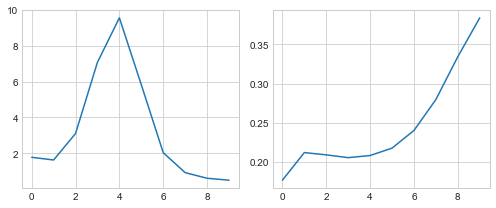

In [27]:
plot_train(losses, accs);

### Embedding plot

In [28]:
def embedding(word_idx):
    if isinstance(word_idx, int):
        subword_idx = wordix_to_subwordix[word_idx]
        u = (model.embedding_z.weight[subword_idx]).sum(dim=0)
    else:    
        subword_idx = get_subword(word_idx)
        u = [model.embedding_z(torch.cuda.LongTensor(subwords)).sum(dim=0)\
                 for subwords in subword_idx]
        u = torch.stack(u)
        
    v = model.embedding_v.weight[word_idx]
    return ((u + v) / 2).cpu()

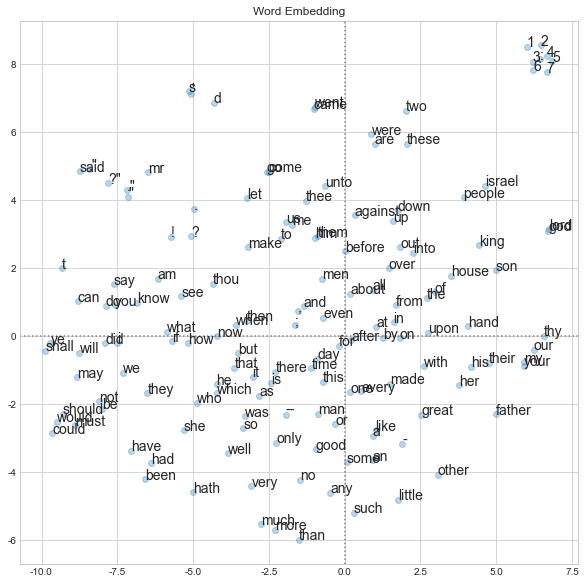

In [29]:
plot_embedding(words, embedding, word_to_ix);

### $n$-most similar

In [30]:
for word in ["angel", "snow", "love", "death"]:
    print(find_similar(word, words, embedding, word_to_ix))

['angels', 'strangely', 'thus', 'saith', 'lord']
['blue', 'figures', 'rolls', 'like', 'mud']
['loved', 'lovers', 'lover', 'my', 'thy']
['thee', 'mercy', 'life', 'breath', 'judgment']
